#Reyes, Marcus 2015-89006
EE 298 M-MOZQ

November 2020

FMLA02 - Numpy Implementation of an MLP

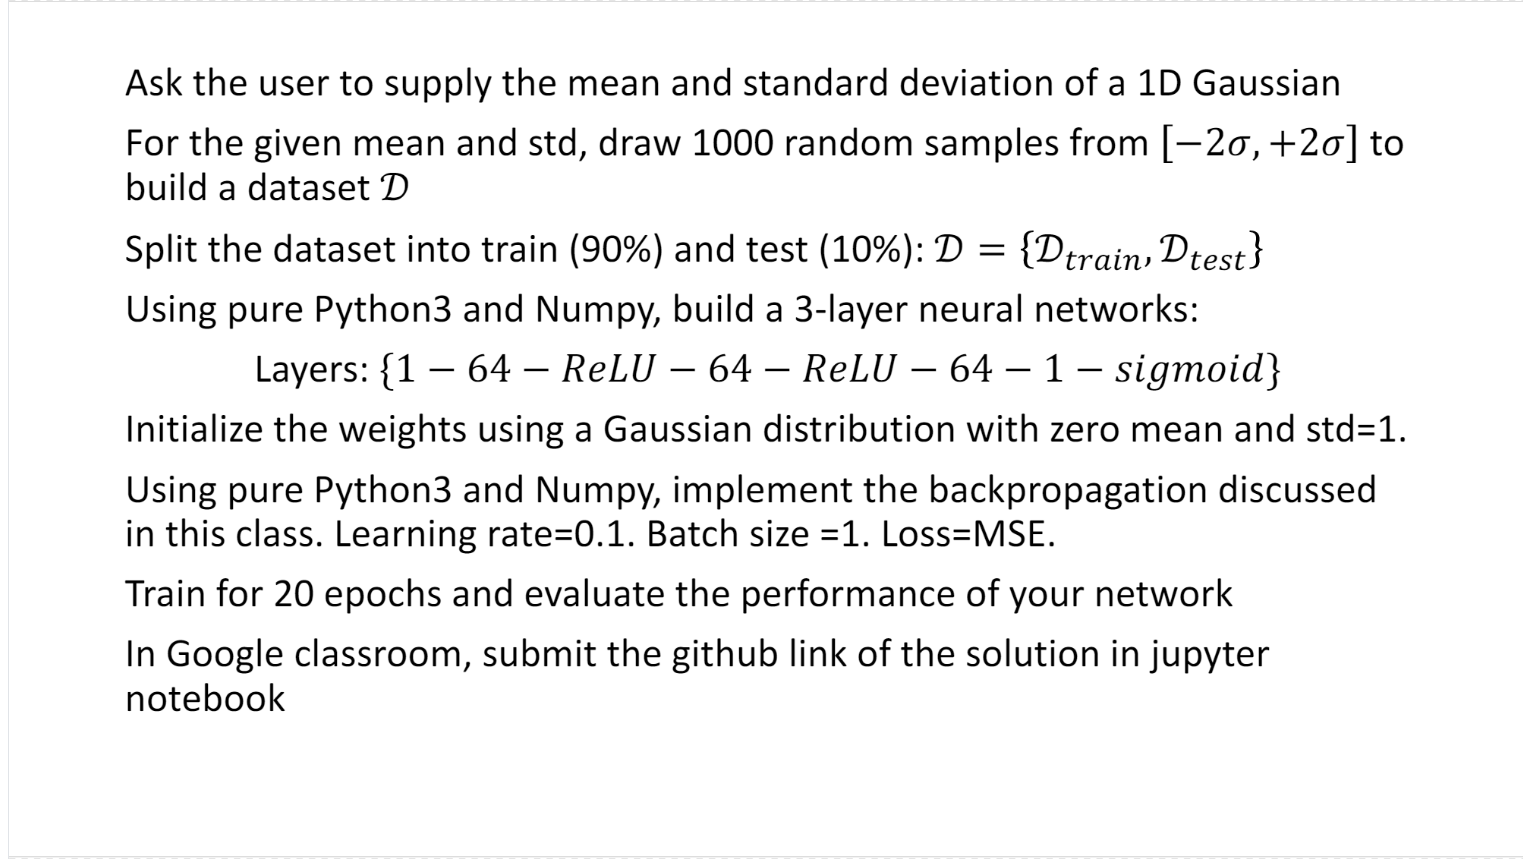

In [1]:
import numpy as np
from math import pi
from matplotlib import pyplot as plt

#Utility Functions

In [2]:
def gaussianpdf(inp, mean, std):
    firstterm = 1/(np.sqrt(2*pi*(std**2)))
    secondterm = np.exp(-((inp-mean)**2)/(2*(std**2)))
    out = firstterm*secondterm
    return out
def sigmoid(x):
    try:
        return 1/(1+np.exp(-x))
    except:
        print("Overflow in sigmoid")
        return np.zeros((1,1))
        

#Dataset Generation

Data mean?0
Data stdev?1
Data Details
Actual Mean:  0.006482836455812733
Actual Std dev:  0.8744006898406875
Min:  -1.9859535530437218
Max:  1.9656696425188347
Plotting Histogram of data


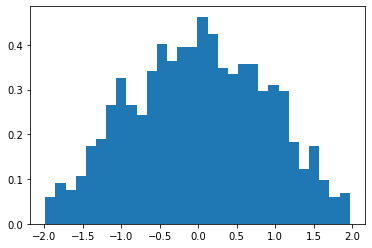

In [3]:
data_mean = float(input("Data mean?"))
data_stdev = float(input("Data stdev?"))

data_gaussian = np.random.normal(data_mean, data_stdev, 1000)
data_list = []
while len(data_list) < 1000:
    temp_data = np.random.normal(data_mean, data_stdev, 1)
    if temp_data > data_mean-2*data_stdev and temp_data < data_mean + 2*data_stdev:
        data_list.append(temp_data)
data_gaussian = np.array(data_list)
data_gaussian = data_gaussian.reshape(1000,1,1)
train_data = data_gaussian[0:900].copy()
test_data = data_gaussian[900:].copy()
print("Data Details")
print("Actual Mean: ", data_gaussian.mean())
print("Actual Std dev: ", data_gaussian.std())
print("Min: ", data_gaussian.min())
print("Max: ",data_gaussian.max())
data_for_plot = data_gaussian.copy().reshape(1000,1)
print("Plotting Histogram of data")
plt.hist(data_for_plot, 30, density = True)
plt.show()


#Network Building

1 - 64 - ReLU - 64 - ReLU - 64 - 1 - sigmoid

In [6]:
class MLP():
    def __init__(self):
        self.net_params = []
        self.net_biases = []
        self.act_list = []
        self.net_params_size = [(1,64), 'relu', (64,64), 'relu', (64,1), 'sigmoid']
        self.net_sequence = ['mlp', 'relu', 'mlp', 'relu', 'mlp', 'sigmoid']
        self.overflowcount = 0
        for i in range(len(self.net_params_size)):
            if self.net_params_size[i] == 'relu':
                self.net_params.append('relu')
                self.net_biases.append('relu')
            elif self.net_params_size[i] == 'sigmoid':
                self.net_params.append('sigmoid')
                self.net_biases.append('sigmoid')
            else:
                self.net_params.append(np.random.normal(0, 1, self.net_params_size[i]))
                self.net_biases.append(np.random.normal(0, 1, self.net_params_size[i][1]))



    def forward(self, inp):
        self.act_list = []
        act = inp #act for activations
        self.act_list.append(act)
        for i in range(len(self.net_params)):
            if i == 1 or i == 3:
            #if self.net_params[i] == 'relu':
            #This conditional raises warnings
                act = act.clip(min = 0)
            elif i == 5:
            #This conditional raises warnings
            #elif self.net_params[i] == 'sigmoid':
                #try except to handle overflows
                try:
                    temp = np.exp(-act)
                    act = 1/(1+temp)
                except:
                    self.overflowcount += 1
                    act = np.zeros((1,1))
            else:
                act = np.matmul(act, self.net_params[i])
                act = act + self.net_biases[i]
            self.act_list.append(act)
        output = act
        return output


    def backprop(self, loss, pred, target):
        #key is swapping when doing the chain rule except for the f term
        #Using the convention f_n = activation(z_n) = activation(w_n-1fn-1 + b_n-1)
        #We have x, W_0, W_1, W_2, f_1, f_2, f_3, z_1, z_2, z_3
        #x => input
        #W_i => weights of nth hidden layer starting at 0
        #z_i => preactivation of output of layer i - 1 also eventually input to hidden layer i
        #f_i => activations of hidden layer i-1 used as input to hidden layer i; such that f_0 == x

        #actlist = [input - z1 - f1 - z2 - f2 - z3 - f3]
        #net_params = [W0, relu, W1, relu, W2, sigmoid]

        ##DLDW2 Computation###################################################
        dldz3 = -2*(target - pred)*(sigmoid(self.act_list[6]))*(1-sigmoid(self.act_list[6]))
        dz3dW2 = self.act_list[4].copy()

        dldW2 = dldz3*dz3dW2
        dldW2 = dldW2.T

        ##DLDW1 Computation####################################################
        dz3df2 = self.net_params[4].copy() #W2

        df2dz2 = self.act_list[4].copy() #f2 since W2 dep on f2
        df2dz2[df2dz2 <= 0] = 0
        df2dz2[df2dz2 > 0] = 1

        dz2dW1 = self.act_list[2].copy()

        #Go from left to right but swapping terms if it does not contain f
        dldW1 = np.matmul(dz3df2, dldz3)
        dldW1 = df2dz2.T*dldW1
        dldW1 = np.matmul(dldW1, dz2dW1)

        #Remember to transpose
        dldW1 = dldW1.T

        #dldW0 Computation####################################################
        ##Needed terms
        dz2df1 = self.net_params[2].copy() #W1

        df1dz1 = self.act_list[2].copy() #f1
        df1dz1[df1dz1 <= 0] = 0
        df1dz1[df1dz1 > 0] = 1

        dz1dW0 = self.act_list[0].copy() #input

        dldW0 = np.matmul(dz3df2, dldz3)
        dldW0 = df2dz2.T*dldW0
        dldW0 = np.matmul(dz2df1, dldW0)
        dldW0 = df1dz1.T*dldW0
        dldW0 = np.matmul(dldW0, dz1dW0)

        #Remember to transpose
        dldW0 = dldW0.T
        
        ###Bias computation###################################################
        #Same as weights but replace all act_lists with 1
        dz3dB2 = np.ones((1,1))
        dldB2 = np.matmul(dldz3, dz3dB2)
        dldB2 = dldB2.T

        dz2dB1 = np.ones((1,1))
        dldB1 = np.matmul(dz3df2, dldz3)
        dldB1 = df2dz2.T*dldB1
        dldB1 = np.matmul(dldB1, dz2dB1)
        dldB1 = dldB1.T

        dz1dB0 = np.ones((1,1))
        dldB0 = np.matmul(dz3df2, dldz3)
        dldB0 = df2dz2.T*dldB0
        dldB0 = np.matmul(dz2df1,dldB0)
        dldB0 = df1dz1.T*dldB0
        dldB0 = np.matmul(dldB0, dz1dB0)
        dldB0 = dldB0.T

        return dldW2, dldW1, dldW0, dldB2, dldB1, dldB0

    def update_weights_and_biases(self,dldW2, dldW1, dldW0, dldB2, dldB1, dldB0, lr = 0.1,):
        self.net_params[0] = self.net_params[0] - lr*dldW0
        self.net_biases[0] = self.net_biases[0] - lr*dldB0

        self.net_params[2] = self.net_params[2] - lr*dldW1
        self.net_biases[2] = self.net_biases[2] - lr*dldB1

        self.net_params[4] = self.net_params[4] - lr*dldW2
        self.net_biases[4] = self.net_biases[4] - lr*dldB2
        return


    def MSEerror(self, prediction, target):
        loss = (target - prediction)**2
        return loss
    


#Network Training

In [7]:
a = MLP()

###Needed for the try except for sigmoid
np.seterr(over = 'raise')

#For plotting the initial guesses of the network on the test data
pretraining_guess_list = []
for i in range(len(test_data)):
    out = a.forward(test_data[i])
    target = gaussianpdf(test_data[i], data_mean, data_stdev)
    loss = a.MSEerror(out, target)
    pretraining_guess_list.append(out[0][0])


#Training the Network
running_loss_list = []
j = 0
max_epochs = 20
while(j < 20):
    lr = 0.1
    j = j + 1
    if (j+1)%10 == 0:
        print("Epoch", j+1)
    running_loss = []
    for i in range(len(train_data)):
        out = a.forward(train_data[i])
        target = gaussianpdf(train_data[i], data_mean, data_stdev)
        loss = a.MSEerror(out, target)
        running_loss.append(loss[0][0])
        dw2,dw1,dw0,db2,db1,db0 = a.backprop(loss, out, target)
        a.update_weights_and_biases(dw2,dw1,dw0,db2,db1,db0, lr = lr)
    running_loss_list.append(sum(running_loss)/len(running_loss))

print("Noting how many times the try except for overflow was used: ", a.overflowcount)

Epoch 10
Epoch 20
Noting how many times the try except for overflow was used:  0


#Results

In [8]:
#Obtain the predictions of the trained network on the test data
output_list = []
for i in range(len(test_data)):
    out = a.forward(test_data[i])
    target = gaussianpdf(test_data[i], data_mean, data_stdev)
    loss = a.MSEerror(out, target)
    output_list.append(out[0][0])

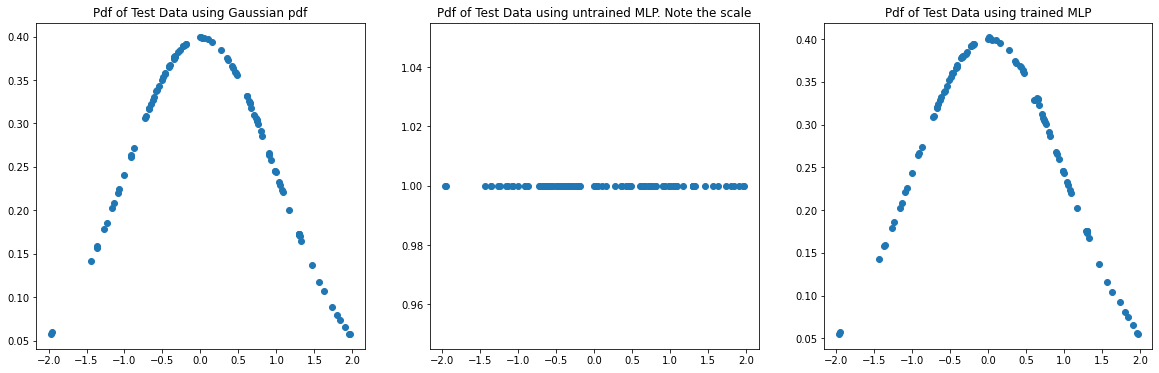

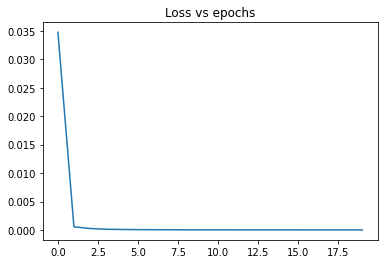

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))


actual_gaussian_pdf_list = []
for i in range(len(test_data)):
    actual_gaussian_pdf_list.append(gaussianpdf(test_data[i], data_mean, data_stdev))


axes[0].scatter(test_data, actual_gaussian_pdf_list)
axes[0].title.set_text('Pdf of Test Data using Gaussian pdf')
axes[1].scatter(test_data, pretraining_guess_list)
axes[1].title.set_text('Pdf of Test Data using untrained MLP. Note the scale')
axes[2].scatter(test_data, output_list)
axes[2].title.set_text('Pdf of Test Data using trained MLP')

plt.figure()
plt.plot(running_loss_list)
output_list = np.array(output_list)
plt.title("Loss vs epochs")
plt.show()
